Подключаемые библиотеки

In [1]:
import re
import random
import urllib2
import math
import numpy as np
import scipy.interpolate as ip
import pandas as pd
import pandas.io.data as web
import matplotlib.pyplot as plt
import scipy.optimize as sco

from bs4 import BeautifulSoup

/usr/lib64/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


Настройки отображения графиков:

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight') # The most fanciest styles are 'ggplot' and 'fivethirtyeight'
# All available styles may be checked by
#print plt.style.available

In [3]:
class sp_500():
    sector_tickers = {}
    symbols = []
    
    def __init__(self):
        self.symbols = []
        self.sector_tickers = dict()
        
        site = "http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        hdr = {'User-Agent': 'Mozilla/5.0'}
        req = urllib2.Request(site, headers=hdr)
        page = urllib2.urlopen(req)
        soup = BeautifulSoup(page, "lxml")

        table = soup.find('table', {'class': 'wikitable sortable'})
    
        for row in table.findAll('tr'):
            col = row.findAll('td')
            if len(col) > 0:
                sector = str(col[3].string.strip()).lower().replace(' ', '_')
                ticker = str(col[0].string.strip())
                date = str(col[6]).replace('<td>', '').replace('</td>', '')
                #if date < historical_end_date:
                if sector not in self.sector_tickers:
                    self.sector_tickers[sector] = list()
                self.sector_tickers[sector].append(ticker)
                self.symbols.append(ticker)
        
       
    # Show sectors summary
    def sectors(self):
        for s in self.sector_tickers:
            print s + ': ' + str(len(self.sector_tickers[s])) + ' companies'
            
    # Show the sector summary and companies in it
    def show(self, sector = None):
        if sector == None:
            self.sectors()
        else:
            print sector + ' sector of S&P500\n' + str(len(self.sector_tickers[sector])) + ' companies:'
            print self.sector_tickers[sector]
    
    # Get the company symbols
    def get(self, sector = None):
        symbols = []
        if sector == None:
            # Get the companies from all S&P500 sectors
            for s in self.sector_tickers:
                for sym in self.sector_tickers[s]:
                    symbols.append(sym)
        else:
            # Get the companies from the given sector
            for sym in self.sector_tickers[sector]:
                symbols.append(sym)
        return symbols
    
    # Get random number of stocks
    def random(self, num):
        return random.sample(self.symbols, num)

Получение наименования компаний, входящих в S&P500 на данный момент (в момент запуска) 

In [5]:
sp500 = sp_500()

In [120]:
class portfolio:
    data = [] # storing stock prices for the companies in the portfolio
    spy = [] # storing SPDR S&P 500 ETF index prices for the given period
    returns = []
    start_prices = []
    end_prices = []

    threshold = 0.01 # the companies with weights below this value are not included in portfolio
    
    # Constructor
    def __init__(self, _symbols, _start, _end, _weights=None):
        # Initializing data
        self.data = pd.DataFrame()
        self.spy = pd.DataFrame()
        self.num_of_days = -1
        self.feasible_returns = []
        self.feasible_volatilities = []
        self.feasible_weights = []
    
        self.effective_volatilities = []
        self.effective_returns = []
        self.effective_weights = []
        
        self.symbols = []
        self.sharpe_symbols = []
        self.min_variance_symbols = []
        
        # 
        self.start = _start
        self.end = _end
        
        self.fetch(_symbols)
        self.set_returns() 
        self.set_start_end_prices()
        
        if _weights != None:
            self.fetch_sp500()
            self.test(_weights)
            self.show_sp500()
    
    # Get percent-view of an number (-24.5% instead of -0.245)
    def percent(self, i):
        formatted = str(i.round(3) * 100) + '%'
        if i > 0:
            formatted = '+' + formatted
        return formatted
    
    #
    def set_days(self):
        for sym in self.symbols:
            if len(self.data[sym]) == self.num_of_days:
                start = str( re.split(' ', str(self.data[sym].axes[0][0]))[0])
                end = str( re.split(' ', str(self.data[sym].axes[0][-1]))[0])
                if self.start != start or self.end != end:
                    self.start = start
                    self.end = end
                    print '\nInvestment period adjusted to ' + self.start + ' - ' + self.end
                return
            
        print 'Error setting investment period'
        return            
    
    # Вычисление логарифмически нормализованых доходностей (отношения уровня закрытия текущего дня к предыдущему) за исторический период   
    def set_returns(self):
        self.returns = np.log(self.data / self.data.shift(1))
    
    # 
    def set_start_end_prices(self):
        self.start_prices = []
        self.end_prices = []
        for sym in self.symbols:
            self.start_prices.append(self.data[sym][self.start])
            self.end_prices.append(self.data[sym][self.end])
    
    # Retrieving stock prices
    def fetch(self, symbols):
        print "Fetching symbols data:"
        for sym in symbols:
            try:
                data = pd.DataFrame()
                data  = web.DataReader(sym, data_source='yahoo', start=self.start, end=self.end)['Adj Close']
                
                if self.num_of_days != -1 and len(data) < self.num_of_days:
                    print sym + ': historical data contains NaN. Excluding'
                    continue
                else:
                    self.symbols.append(sym)
                    self.data[sym] = data
                    if self.data[sym].size != self.num_of_days:
                        self.num_of_days = self.data[sym].size
            except IOError:
                print sym + ': no data available for requested period'
                continue

        self.data.column = self.symbols
        self.set_days()
        print 'Data fetched for ' + str(len(self.symbols)) + ' symbols and '+ str(self.num_of_days)  + ' trading days'
        return
    
    # Retrieving data for SPDR S&P 500 ETF index:
    def fetch_sp500(self):
        self.spy = web.DataReader('^GSPC', data_source='yahoo', start=self.start, end=self.end)['Adj Close']
        self.spy.column = '^GSPC'
        
    #
    def show(self, weights):
        print "Investment period: " + self.start + " - " + self.end
        
        print "Portfolio volatility: " + str( self.statistics(weights)[0].round(3) )
        print "Portfolio return: " + str( self.statistics(weights)[1].round(3) )   
        print "Sharpe ratio: "  + str( self.statistics(weights)[2].round(3) )  
        
        print "Portfolio weights:"    
        for sym, w in zip(self.symbols, weights):
            if w > self.threshold:
                print sym + ': ' + str(w.round(3))
    
    # Show the line with symbol statistics
    # AAPL: 67.802 -> 72.73 (+7.3%)
    def show_symbol(self, sym, weight, start_price, end_price, return_rate):
        if weight == None:
            print sym + ': ' + str(start_price.round(2)) + ' -> ' + str(end_price.round(2)) + ' (' + self.percent(return_rate) + ')'
        else:
            print sym + ' (' + str(weight) + '): ' + str(start_price.round(2)) + ' -> ' + str(end_price.round(2)) + ' (' + self.percent(return_rate) + ')'
    #
    def show_sp500(self):
        start = self.spy[self.start]
        end = self.spy[self.end]
        return_rate = (end - start) / start
        self.show_symbol('S&P500', None, start, end, return_rate)

    #
    def test(self, weights):     
        portfolio_start = 0
        portfolio_end = 0
        
        for s, sp, ep, w in zip(self.symbols, self.start_prices, self.end_prices, weights):
            ret = (ep - sp) / sp  
            portfolio_start = portfolio_start + sp * w
            portfolio_end = portfolio_end + ep * w
            self.show_symbol(s, w, sp, ep, ret)
            
        portfolio_return = (portfolio_end - portfolio_start) / portfolio_start
        print '\nPortfolio return: ' + self.percent(portfolio_return)
        
        return
    
    #
    def calc(self, _min_return, _max_return, _step, _precision):
        self.min_return = _min_return # minimal return value 
        self.max_return = _max_return # maximum return value
        self.step = _step
        self.precision = _precision
        
        self.get_effective_set()
        print '\nThe highest Sharpe ratio portfolio: '
        self.show( self.get_max_sharpe_weights() )
        
        print '\nThe minimal variance porfolio: '
        self.show( self.get_min_variance_weights() )
        
    
    # 
    def get_risky(self):
        if len(self.sharpe_symbols) > 0:
            return self.sharpe_symbols, self.sharpe_weights
        else:
            print 'The optimal portfolio is not calculated. Run calc() first'
            
    #
    def get_conservative(self):
        if len(self.min_variance_symbols) > 0:
            return self.min_variance_symbols, self.min_variance_weights
        else:
            print 'The optimal portfolio is not calculated. Run calc() first'
        return
    
    # Вычисление эффективного множества (effective set)
    def get_effective_set(self):
        self.effective_volatilities = []
        self.effective_returns = []
        self.effective_weights = []
    
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bnds = tuple((0, 1) for x in range(len(self.symbols)))

        for y in np.linspace(self.min_return, self.max_return, self.step):
            cons = ({'type': 'eq', 'fun': lambda x: self.statistics(x)[1] - y}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            if self.precision != None:
                result = sco.minimize(self.min_volatility, len(self.symbols) * [1. / len(self.symbols),], method='SLSQP', bounds=bnds, constraints=cons, options={'ftol':self.precision})
            else:
                result = sco.minimize(self.min_volatility, len(self.symbols) * [1. / len(self.symbols),], method='SLSQP', bounds=bnds, constraints=cons)
            self.effective_volatilities.append(result['fun'])
            self.effective_returns.append(y)
            self.effective_weights.append(result['x'])
    
        self.effective_volatilities = np.array(self.effective_volatilities)
        self.effective_returns = np.array(self.effective_returns)
        self.effective_weights = np.array(self.effective_weights)

    # Функция, получающая веса бумаг в портфеле в качестве входных параметров, и возвращающая массив 
    # данных о портфеле в формате [волатильность, доходность, коэффициент Шарпа]
    def statistics(self, weights):
        weights = np.array(weights)
        portfolio_return = self.get_portfolio_return(weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov() * self.num_of_days, weights)))
    
        return np.array([portfolio_volatility, portfolio_return, portfolio_return / portfolio_volatility])
    
    # Функция вычисления минимального отклонения
    def min_volatility(self, weights):
        return self.statistics(weights)[0]
    
    # Функция вычисления доходности портфеля
    def get_portfolio_return(self, weights):
        portfolio_start_price = 0
        portfolio_end_price = 0

        for w, sp, ep in zip(weights, self.start_prices, self.end_prices):
            portfolio_start_price = portfolio_start_price + w * sp
            portfolio_end_price = portfolio_end_price + w * ep
        
        try:
            return ((portfolio_end_price - portfolio_start_price) / portfolio_start_price)
        except ZeroDivisionError:
            print 'Zero division exception'
            print weights
            return 0
        #return np.sum(returns.mean() * weights) * num_of_days
    
    
    # Функция вычисления портфеля с приемлемым уровнем риска
    def get_acceptable(self, _max_risk):
        volatility = 0 
        weights = []
        for r, v, w in zip(self.effective_returns, self.effective_volatilities, self.effective_weights):
            if v >= volatility:
                if v <= _max_risk:
                    weights = w

        self.acceptable_symbols = []
        self.acceptable_weights = []
        for sym, w in zip(self.symbols, weights):
            if w > self.threshold:
                self.acceptable_symbols.append(sym)
                self.acceptable_weights.append(w.round(3))
        
        return self.acceptable_symbols, self.acceptable_weights
    
    # Функция вычисления портфеля с максимальным коэффицентом Шарпа (отношением доходность/волатильность)
    def get_max_sharpe_weights(self):
        max_sharpe = 0
        weights = []
        for r, v, w in zip(self.effective_returns, self.effective_volatilities, self.effective_weights):
            if r / v > max_sharpe:
                max_sharpe =  r / v
                weights = w
                
        self.sharpe_symbols = []
        self.sharpe_weights = []
        for sym, w in zip(self.symbols, weights):
            if w > self.threshold:
                self.sharpe_symbols.append(sym)
                self.sharpe_weights.append(w.round(3)) # FIXME: shoudn't round value maybe
        
        return weights
    
    #
    def get_min_variance_weights(self):
        min_variance = 10
        weights = []
        for v, w in zip(self.effective_volatilities, self.effective_weights):
            if v < min_variance:
                min_variance =  v
                weights = w
                
        self.min_variance_symbols = []
        self.min_variance_weights = []
        for sym, w in zip(self.symbols, weights):
            if w.round(3) > 0.001:
                self.min_variance_symbols.append(sym)
                self.min_variance_weights.append(w.round(3)) # FIXME: shoudn't round value maybe

        return weights
    
    def plot(self):
        plt.figure(figsize=(12, 6))

        x_sharpe = self.statistics(self.get_max_sharpe_weights())[0]
        y_sharpe = self.statistics(self.get_max_sharpe_weights())[1]

        x_min_vol = self.statistics(self.get_min_variance_weights())[0]
        y_min_vol = self.statistics(self.get_min_variance_weights())[1]

        #plt.scatter(feasible_volatilities, feasible_returns, c = feasible_returns / feasible_volatilities, marker='o')
        plt.scatter(self.effective_volatilities, self.effective_returns, c = self.effective_returns / self.effective_volatilities, marker='x')
        plt.plot(x_sharpe, y_sharpe, 'rs', markersize=8.0) # portfolio with highest Sharpe ratio
        plt.plot(x_min_vol, y_min_vol, 'ys', markersize=8.0) # portfolio with highest Sharpe ratio

        plt.colorbar(label='Sharpe ratio')
        plt.xlabel(r'$\sigma_p$')
        plt.ylabel(r'$\bar{r_p}$')
        

In [121]:
p = portfolio(sp500.random(20), '2013-01-01', '2015-01-01')

Fetching symbols data:

Investment period adjusted to 2013-01-02 - 2014-12-31
Data fetched for 20 symbols and 504 trading days


Вычисление оптимальных портфелей. 
Передаваемые аргументы (минимальная доходность, максимальная доходность, шаг, точность вычислений) имееют решающее значение для времени вычисления оптимального портфеля.
Точность ниже 1e-03 приводит к прерывистому или неровному характеру эффективного множества.

In [122]:
%time p.calc(0.0, 0.7, 30, 1e-02)


The highest Sharpe ratio portfolio: 
Investment period: 2013-01-02 - 2014-12-31
Portfolio volatility: 0.183
Portfolio return: 0.696
Sharpe ratio: 3.808
Portfolio weights:
AVB: 0.016
NDAQ: 0.096
ACN: 0.027
LLL: 0.14
TSS: 0.05
PDCO: 0.077
WFC: 0.088
UDR: 0.076
WHR: 0.166
JBHT: 0.041
ZBH: 0.124
BXP: 0.032
STX: 0.067

The minimal variance porfolio: 
Investment period: 2013-01-02 - 2014-12-31
Portfolio volatility: 0.155
Portfolio return: 0.411
Sharpe ratio: 2.646
Portfolio weights:
AVB: 0.113
NDAQ: 0.069
ACN: 0.069
LLL: 0.077
TSS: 0.062
PDCO: 0.101
URBN: 0.03
WFC: 0.081
PVH: 0.044
UDR: 0.104
JBHT: 0.07
ZBH: 0.067
BXP: 0.09
F: 0.024
CPU times: user 5.44 s, sys: 1 ms, total: 5.44 s
Wall time: 5.44 s


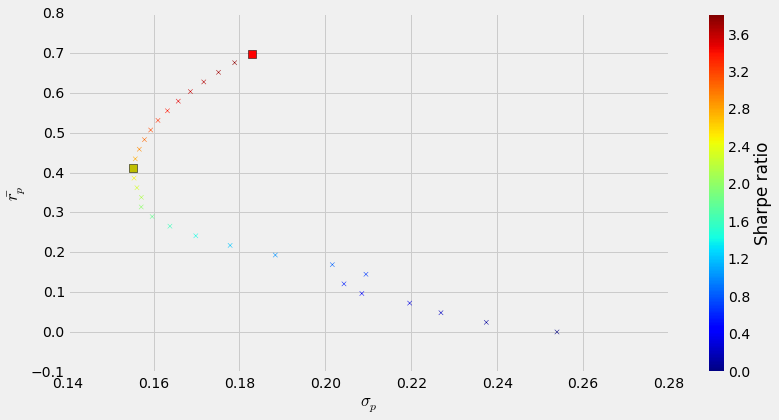

In [123]:
p.plot()

Проверяем доходности полученных оптимальных портфелей на нужном промежутке времени. Значение max_risk должно быть выбрано инвестором на основании построенного выше эффективного множества, и это значение волатильности должно находиться в промежутке между портфелем с минимальной волатильностью и портфелем с максимальным коэффициентом Шарпа

In [99]:
start_date = '2015-01-01'
end_date = '2016-01-01'

In [100]:
max_risk = 0.15
r = portfolio(p.get_acceptable(max_risk)[0], start_date, end_date, p.get_acceptable(max_risk)[1])

Fetching symbols data:

Investment period adjusted to 2015-01-02 - 2015-12-31
Data fetched for 12 symbols and 252 trading days
TWX (0.05): 82.9 -> 64.28 (-22.5%)
HAS (0.087): 53.23 -> 66.93 (+25.7%)
DTE (0.127): 83.88 -> 80.19 (-4.4%)
RF (0.01): 10.19 -> 9.53 (-6.5%)
BBT (0.067): 37.3 -> 37.49 (+0.5%)
BCR (0.197): 166.4 -> 189.18 (+13.7%)
MSFT (0.077): 45.2 -> 55.08 (+21.9%)
PPL (0.148): 34.31 -> 33.77 (-1.6%)
EQR (0.072): 63.64 -> 72.83 (+14.4%)
DE (0.033): 85.82 -> 76.27 (-11.1%)
GPC (0.113): 102.88 -> 85.28 (-17.1%)
CTL (0.019): 36.28 -> 24.72 (-31.9%)

Portfolio return: +3.7%
S&P500: 2058.2 -> 2043.94 (-0.7%)





Оптимальный портфель (портфель с максимальным коэффициентом Шарпа):

In [101]:
r = portfolio(p.get_risky()[0], start_date, end_date, p.get_risky()[1])

Fetching symbols data:

Investment period adjusted to 2015-01-02 - 2015-12-31
Data fetched for 8 symbols and 252 trading days
TWX (0.082): 82.9 -> 64.28 (-22.5%)
HAS (0.079): 53.23 -> 66.93 (+25.7%)
DTE (0.05): 83.88 -> 80.19 (-4.4%)
BBT (0.027): 37.3 -> 37.49 (+0.5%)
BCR (0.231): 166.4 -> 189.18 (+13.7%)
MSFT (0.12): 45.2 -> 55.08 (+21.9%)
PPL (0.203): 34.31 -> 33.77 (-1.6%)
GPC (0.198): 102.88 -> 85.28 (-17.1%)

Portfolio return: +2.6%
S&P500: 2058.2 -> 2043.94 (-0.7%)


Оптимальный портфель (с минимальной волатильностью)

In [102]:
c = portfolio(p.get_conservative()[0], start_date, end_date, p.get_conservative()[1])

Fetching symbols data:

Investment period adjusted to 2015-01-02 - 2015-12-31
Data fetched for 15 symbols and 252 trading days
GOOGL (0.02): 529.55 -> 778.01 (+46.9%)
CVX (0.105): 106.35 -> 88.83 (-16.5%)
TWX (0.002): 82.9 -> 64.28 (-22.5%)
HAS (0.07): 53.23 -> 66.93 (+25.7%)
DTE (0.087): 83.88 -> 80.19 (-4.4%)
BBT (0.068): 37.3 -> 37.49 (+0.5%)
BCR (0.104): 166.4 -> 189.18 (+13.7%)
MSFT (0.04): 45.2 -> 55.08 (+21.9%)
PPL (0.137): 34.31 -> 33.77 (-1.6%)
EQR (0.079): 63.64 -> 72.83 (+14.4%)
VTR (0.052): 68.89 -> 55.72 (-19.1%)
DE (0.155): 85.82 -> 76.27 (-11.1%)
FMC (0.042): 56.13 -> 39.13 (-30.3%)
GPC (0.017): 102.88 -> 85.28 (-17.1%)
CTL (0.024): 36.28 -> 24.72 (-31.9%)

Portfolio return: +4.3%
S&P500: 2058.2 -> 2043.94 (-0.7%)
